# Energy-Based models and structured prediction

In this assignment we're going to work with structured prediction. Structured prediction broadly refers to any problem involving predicting structured values, as opposed to plain scalars. Examples of structured outputs include graphs and text.

We're going to work with text. The task is to transcribe a word from an image. The difficulty here is that different words have different lengths, so we can't just have fixed number of outputs.

Furthermore, we will be comparing model trained with our DP solution to model trained with GTN framework.

# GTN Framework

GTN framework has support for finding Viterbi paths and training the prediction. The below links can be helpful in solving this homework\:
- [CTC](https://distill.pub/2017/ctc/)
- [Weighted Automata in ML](https://awnihannun.com/writing/automata_ml/automata_in_machine_learning.pdf)

Additional Links\:
- [GTN Documentation](https://gtn.readthedocs.io/en/latest/)
- [GTN Applications](https://github.com/facebookresearch/gtn_applications)

## Dataset
As always, the first thing to do is implementing the dataset. We're going to create a dataset that creates images of random words. We'll also include some augmentations, such as jitter (moving the character horizontally).

In [1]:
! mkdir fonts
! curl --output fonts/font.zip https://www.fontsquirrel.com/fonts/download/Anonymous
! unzip -n fonts/font.zip -d fonts

mkdir: cannot create directory ‘fonts’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29805  100 29805    0     0   215k      0 --:--:-- --:--:-- --:--:--  215k
Archive:  fonts/font.zip


torch.Size([32, 18])


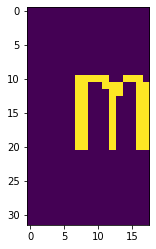

In [1]:
'''
Author: Xiang Pan
Date: 2022-03-05 01:56:18
LastEditTime: 2022-03-09 07:26:14
LastEditors: Xiang Pan
Description: 
FilePath: /HW3/hw3_practice.ipynb
@email: xiangpan@nyu.edu
'''
from PIL import ImageDraw, ImageFont
import string
import random
import torch
import torchvision
from torchvision import transforms
from PIL import Image # PIL is a library to process images
from matplotlib import pyplot as plt

simple_transforms = transforms.Compose([
                                    transforms.ToTensor(), 
                                ])

class SimpleWordsDataset(torch.utils.data.IterableDataset):

    def __init__(self, max_length, len=100, jitter=False, noise=False):
        self.max_length = max_length
        self.transforms = transforms.ToTensor()
        self.len = len
        self.jitter = jitter
        self.noise = noise

    def __len__(self):
        return self.len

    def __iter__(self):
        for _ in range(self.len):
            text = ''.join([random.choice(string.ascii_lowercase) for i in range(self.max_length)])
            img = self.draw_text(text, jitter=self.jitter, noise=self.noise)
            yield img, text

    def draw_text(self, text, length=None, jitter=False, noise=False):
        if length == None:
            length = 18 * len(text)
        img = Image.new('L', (length, 32))
        fnt = ImageFont.truetype("fonts/Anonymous.ttf", 20)

        d = ImageDraw.Draw(img)
        pos = (0, 5)
        if jitter:
            pos = (random.randint(0, 7), 5)
        else:
            pos = (0, 5)
        d.text(pos, text, fill=1, font=fnt)

        img = self.transforms(img)
        img[img > 0] = 1 

        if noise:
            img += torch.bernoulli(torch.ones_like(img) * 0.1)
            img = img.clamp(0, 1)
            

        return img[0]

sds = SimpleWordsDataset(1, jitter=True, noise=False)
img = next(iter(sds))[0]
print(img.shape)
plt.imshow(img)

We can look at what the entire alphabet looks like in this dataset.

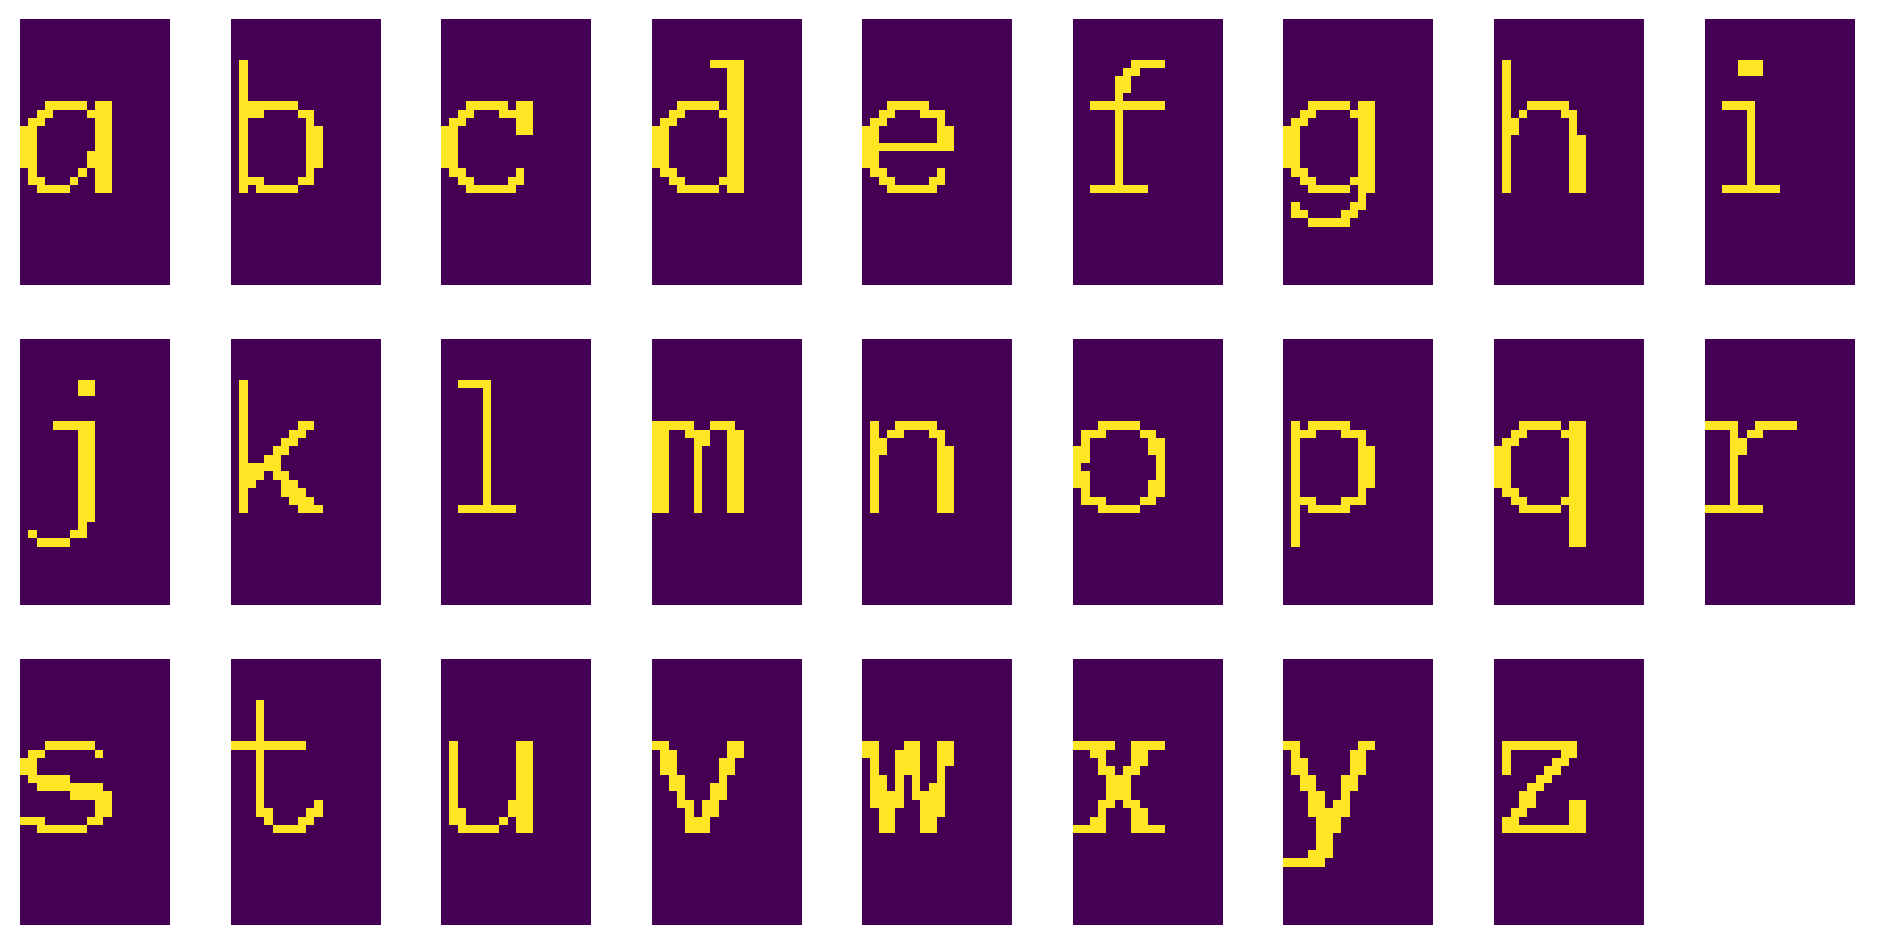

In [2]:
fig, ax = plt.subplots(3, 9, figsize=(12, 6), dpi=200)

for i, c in enumerate(string.ascii_lowercase):
    row = i // 9
    col = i % 9
    ax[row][col].imshow(sds.draw_text(c))
    ax[row][col].axis('off')
ax[2][8].axis('off')
    
plt.show()

We can also put the entire alphabet in one image.

(-0.5, 339.5, 31.5, -0.5)

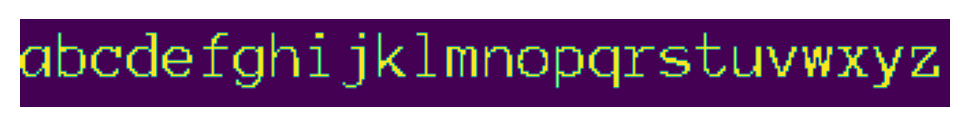

In [3]:
alphabet = sds.draw_text(string.ascii_lowercase, 340)
plt.figure(dpi=200)
plt.imshow(alphabet)
plt.axis('off')

## Model definition
Before we define the model, we define the size of our alphabet. Our alphabet consists of lowercase English letters, and additionally a special character used for space between symbols or before and after the word. For the first part of this assignment, we don't need that extra character.

Our end goal is to learn to transcribe words of arbitrary length. However, first, we pre-train our simple convolutional neural net to recognize single characters. In order to be able to use the same model for one character and for entire words, we are going to design the model in a way that makes sure that the output size for one character (or when input image size is 32x18) is 1x27, and Kx27 whenever the input image is wider. K here will depend on particular architecture of the network, and is affected by strides, poolings, among other things. 
A little bit more formally, our model $f_\theta$, for an input image $x$ gives output energies $l = f_\theta(x)$. If $x \in \mathbb{R}^{32 \times 18}$, then $l \in \mathbb{R}^{1 \times 27}$.
If $x \in \mathbb{R}^{32 \times 100}$ for example, our model may output $l \in \mathbb{R}^{10 \times 27}$, where $l_i$ corresponds to a particular window in $x$, for example from $x_{0, 9i}$ to $x_{32, 9i + 18}$ (again, this will depend on the particular architecture).

Below is a drawing that explains the sliding window concept. We use the same neural net with the same weights to get $l_1, l_2, l_3$, the only difference is receptive field. $l_1$ is looks at the leftmost part, at character 'c', $l_2$ looks at 'a', and $l_3$ looks at 't'. The receptive field may or may not overlap, depending on how you design your convolutions.

![cat.png](https://i.imgur.com/JByfyKh.png)

In [4]:
# constants for number of classes in total, and for the special extra character for empty space
ALPHABET_SIZE = 27
BETWEEN = 26

In [5]:
import torch.nn as nn
# sliding window cnn
class SimpleNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.filters = [8, 16, 32]
        self.width = 18 
        self.cnn_block = []
        self.cnn_block = torch.nn.Sequential(
            # TODO
            torch.nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(32, ALPHABET_SIZE, kernel_size=3, stride=1, padding=1),
            # nn.MaxPool1d(1)
        )
        # self.mlp = nn.Linear(self.width, 1)

    def forward(self, x):
        # after applying cnn_block, x.shape should be:
        # batch_size, alphabet_size, 1, width
        batch_size = x.shape[0]

        logit = self.cnn_block(x)
        logit = logit.view(batch_size, ALPHABET_SIZE, 1, -1).squeeze(2)
        logit = logit.permute(0, 2, 1)

        return logit


In [6]:
dummy_input = torch.randn(1, 1, 32, 18)
net = SimpleNet()
logit = net(dummy_input)
print(logit.shape)

torch.Size([1, 8, 27])


Let's initalize the model and apply it to the alphabet image:

In [191]:
model = SimpleNet()
print(alphabet.shape)
alphabet_energies = model(alphabet.view(1, 1, *alphabet.shape))
alphabet_energies.shape

torch.Size([32, 340])


torch.Size([1, 168, 27])

torch.Size([1, 168, 27])


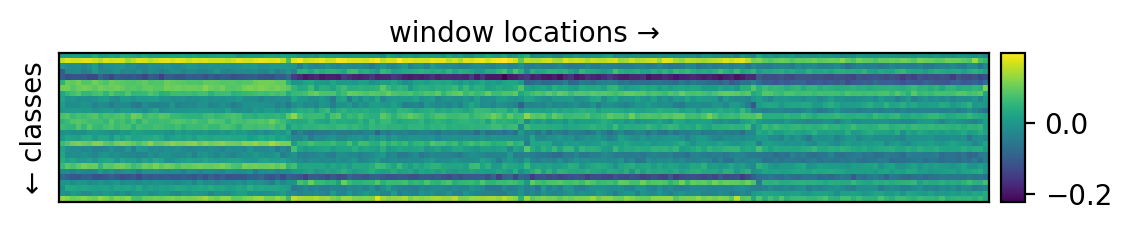

In [7]:
model = SimpleNet()
alphabet_energies = model(alphabet.view(1, 1, *alphabet.shape))

def plot_energies(ce):
    fig=plt.figure(dpi=200)
    ax = plt.axes()
    im = ax.imshow(ce.cpu().T)

    ax.set_xlabel('window locations →')
    ax.set_ylabel('← classes')
    ax.xaxis.set_label_position('top') 
    ax.set_xticks([])
    ax.set_yticks([])

    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im, cax=cax) 

print(alphabet_energies.shape)
plot_energies(alphabet_energies[0].detach())

So far we only see random outputs, because the classifier is untrained.

## Train with one character

Now we train the model we've created on a dataset where images contain only single characters. Note the changed cross_entropy function.

In [23]:
from tqdm.notebook import tqdm
import torch.optim as optim

def cross_entropy(energies, *args, **kwargs):
    """ We use energies, and therefore we need to use log soft arg min instead
        of log soft arg max. To do that we just multiply energies by -1. """
    return nn.functional.cross_entropy(-1 * energies, *args, **kwargs)

def simple_collate_fn(samples):
    images, annotations = zip(*samples)
    images = list(images)
    annotations = list(annotations)
    annotations = list(map(lambda c : torch.tensor(ord(c) - ord('a')), annotations))
    m_width = max(18, max([i.shape[1] for i in images]))
    for i in range(len(images)):
        images[i] = torch.nn.functional.pad(images[i], (0, m_width - images[i].shape[-1]))
        
    if len(images) == 1:
        return images[0].unsqueeze(0), torch.stack(annotations)
    else:
        return torch.stack(images), torch.stack(annotations)

In [24]:

sds = SimpleWordsDataset(1, len=1000, jitter=True, noise=False)
dataloader = torch.utils.data.DataLoader(sds, batch_size=16, num_workers=0, collate_fn=simple_collate_fn)

model.cuda()
# TODO: initialize optimizer, train the model on the one-character dataset

SimpleNet(
  (cnn_block): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 27, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [25]:
for batch in dataloader:
    print(batch[0].shape)
    break

torch.Size([16, 32, 18])


In [26]:
model = SimpleNet().cuda()
dummy_input = torch.randn(16, 1, 32, 18).cuda()
output = model(dummy_input)
print(output.shape)

torch.Size([16, 8, 27])


In [27]:
def train_model(model, epochs, dataloader, criterion, optimizer):
    for epoch in range(epochs):
        for i, (img, text) in enumerate(dataloader):
            img = img.cuda()
            img = img.unsqueeze(1)
            text = text.cuda()
            optimizer.zero_grad()
            energy = model(img)[:,0,:]
            acc = (energy.argmin(dim=-1) == text).float().mean()
            loss = criterion(energy, text)
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                print(f'Epoch {epoch}, iteration {i}, loss {loss.item():.4f}, acc {acc.item():.4f}')

In [28]:
model = SimpleNet().cuda()
model = model.cuda()
train_model(model, epochs=20, dataloader=dataloader, criterion=cross_entropy, optimizer=optim.Adam(model.parameters(), lr=0.005))

Epoch 0, iteration 0, loss 3.2903, acc 0.0000
Epoch 1, iteration 0, loss 2.0893, acc 0.4375
Epoch 2, iteration 0, loss 0.4640, acc 0.8125
Epoch 3, iteration 0, loss 0.0986, acc 1.0000
Epoch 4, iteration 0, loss 0.1380, acc 0.9375
Epoch 5, iteration 0, loss 0.0421, acc 1.0000
Epoch 6, iteration 0, loss 0.0085, acc 1.0000
Epoch 7, iteration 0, loss 0.0019, acc 1.0000
Epoch 8, iteration 0, loss 0.0230, acc 1.0000
Epoch 9, iteration 0, loss 0.1234, acc 0.9375
Epoch 10, iteration 0, loss 0.0026, acc 1.0000
Epoch 11, iteration 0, loss 0.1290, acc 0.9375
Epoch 12, iteration 0, loss 0.0016, acc 1.0000
Epoch 13, iteration 0, loss 0.0024, acc 1.0000
Epoch 14, iteration 0, loss 0.0006, acc 1.0000
Epoch 15, iteration 0, loss 0.0009, acc 1.0000
Epoch 16, iteration 0, loss 0.0010, acc 1.0000
Epoch 17, iteration 0, loss 0.0010, acc 1.0000
Epoch 18, iteration 0, loss 0.0004, acc 1.0000
Epoch 19, iteration 0, loss 0.0001, acc 1.0000


In [29]:
def get_accuracy(model, dataset):
    cnt = 0
    for i, l in dataset:
        # energies = model(i.unsqueeze(0).unsqueeze(0).cuda())[0, 0]
        energies = model(i.unsqueeze(0).unsqueeze(0).cuda())[0, 0]
        x = energies.argmin(dim=-1)
        cnt += int(x == (ord(l[0]) - ord('a')))
    return cnt / len(dataset)
        
tds = SimpleWordsDataset(1, len=100)
assert get_accuracy(model, tds) == 1.0, 'Your model doesn\'t achieve 100% accuracy for 1 character'

In [30]:
print(get_accuracy(model, tds))

1.0


Now, to see how our model would work with more than one character, we apply the model to a bigger input - the image of the alphabet we saw earlier. We extract the energies for each window and show them.

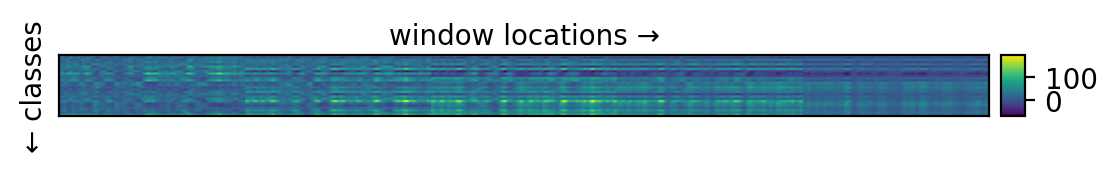

In [169]:
alphabet_energies_post_train = model(alphabet.cuda().view(1, 1, *alphabet.shape))
plot_energies(alphabet_energies_post_train[0].detach())

Explain any classes that are lit up. What is still missing to be able to use it for transcription of words?

Answer: 
The classes lit up are class with high energy(low possibility). We need to match the energy locations with the character locations.

## Training with multiple characters

Now, we want to train our model to not only recognize the letters, but also to recognize space in-between so that we can use it for transcription later.

This is where complications begin. When transcribing a word from an image, we don't know beforehand how long the word is going to be. We can use our convolutional neural network we've pretrained on single characters to get prediction of character probabilities for all the positions of an input window in the new input image, but we don't know beforehand how to match those predictions with the target label. Training with incorrect matching can lead to wrong model, so in order to be able to train a network to transcribe words, we need a way to find these pairings.

![dl.png](https://i.imgur.com/7pnodfV.png)

The importance of pairings can be demonstrated by the drawing above. If we map $l_1, l_2, l_3, l_4$ to 'c', 'a', 't', '_' respectively, we'll correctly train the system, but if we put $l_1, l_2, l_3, l_4$ with 'a', 'a', 't', 't', we'd have a very wrong classifier.

To formalize this, we use energy-based models' framework. Let's define the energy $E(x, y, z)$ as the sum of cross-entropies for a particular pairing between probabilities our model gives for input image $x$ and text transcription $y$, and pairing $z$. $z$ is a function $z : \{1, 2, \dots, \vert l \vert \} \to \{1, 2, \dots, \vert y \vert)$, $l$ here is the energies output of our convolutional neural net $l = f_\theta(x)$. $z$ maps each energy vector in $l$ to an element in the output sequence $y$. We want the mappings to make sense, so $z$ should be a non-decreasing function $z(i) \leq z(i+1)$, and it shouldn't skip characters, i.e. $\forall_i \exists_j z(j)=i$.

Energy is then $E(x, y, z) = C(z) + \sum_{i=1}^{\vert l \vert} l_i[z(i)]$
,  $C(z)$ is some extra term that allows us to penalize certain pairings, and $l_i[z(i)]$ is the energy of $z(i)$-th symbol on position $i$.

In this particular context, we define $C(z)$ to be infinity for impossible pairings:
$$C(z) = \begin{cases}
\infty \; \text{if} \; z(1) \neq 1 \vee z(\vert l \vert) \neq \vert y \vert \vee \exists_{i, 1\leq 1 \leq \vert l \vert - 1} z(i) > z(i+1) \vee z(i) < z(i+1) - 1\\
0 \; \text{otherwise}
\end{cases}
$$


Then, the free energy $F(x, y) = \arg \min_z E(x, y, z)$. In other words, the free energy is the energy of the best pairing between the probabilities provided by our model, and the target labels.

When training, we are going to use cross-entropies along the best path: $\ell(x, y, z) = \sum_{i=1}^{\vert l \vert}H(y_{z(i)}, \sigma(l_i))$, where $H$ is cross-entropy, $\sigma$ is soft-argmin needed to convert energies to a distribution.

First, let's write functions that would calculate the needed cross entropies $H(y_{z(i)}, \sigma(l_i))$, and energies for us.

## build_path_matrix and build_ce_matrix

In [39]:
'''
Author: Xiang Pan
Date: 2022-03-04 22:44:31
LastEditTime: 2022-03-09 23:25:31
LastEditors: Xiang Pan
Description: 
FilePath: /HW3/hw3_practice.ipynb
@email: xiangpan@nyu.edu
'''
def build_path_matrix(energies, targets):
    # inputs: 
    #    energies, shape is BATCH_SIZE x L x 27
    #    targets, shape is BATCH_SIZE x T
    # L is \vert l \vert
    # T is \vert y \vert
    # 
    # outputs:
    #    a matrix of shape BATCH_SIZE x L x T
    #    where output[i, j, k] = energies[i, j, targets[i, k]]
    #
    # Note: you're not allowed to use for loops. The calculation has to be vectorized.
    # you may want to use repeat and repeat_interleave.
    # TODO
    # energy = [batch_size, L, 27]
    # target = [batch_size, T]
    # output[i, j, k] = energies[i, j, targets[i,j,k]]
    outputs = torch.zeros(energies.shape[0], energies.shape[1], targets.shape[1])
    outputs = torch.gather(input=energies, dim=2, index=targets.unsqueeze(1).repeat(1, energies.shape[1], 1))
    return outputs

def build_ce_matrix(energies, targets):
    # inputs: 
    #    energies, shape is BATCH_SIZE x L x 27
    #    targets, shape is BATCH_SIZE x T
    # L is \ververtt = targets.unsqueeze(1).repeat(1,energies.shape[1],1)t l \vert
    # T is \vert y \vert
    # 
    # outputs:
    #    a matrix ce of shape BATCH_SIZE x L x T
    #    where ce[i, j, k] = cross_entropy(energies[i, j], targets[i, k])
    #
    # Note: you're not allowed to use for loops. The calculation has to be vectorized.
    # you may want to use repeat and repeat_interleave.
    # TODO
    # energy = [batch_size, L, 27]
    # target = [batch_size, T]
    # ce[i, j, k] = cross_entropy(energies[i, j], tarLgets[i, k])
    # assert ce[b, i, j] == cross_entropy(energies[b, i].unsqueeze(0), 
    #                                     targets[b, j].to(energies.device).unsqueeze(0))
    batch_size = energies.shape[0]
    L = energies.shape[1]
    T = targets.shape[1]
    # energy = [batch_size, L, T, 27]
    energies = energies.unsqueeze(2).repeat(1, 1, T, 1)
    # target = [batch_size, L, T]
    targets = targets.unsqueeze(1).repeat(1, L, 1)
    # targets = torch.nn.functional.one_hot(targets, 27)
    energies = energies.reshape(batch_size * L * T, 27)
    targets = targets.reshape(batch_size * L * T)
    ce = torch.nn.functional.cross_entropy(-energies, targets, reduction='none')
    ce = ce.reshape(batch_size, L, T)
    return ce
    

# code to test your implementation 
for _ in range(10):
    energies = torch.randn(8, 20, ALPHABET_SIZE) 
    targets = torch.randint(ALPHABET_SIZE, (8, 20))
    pm = build_path_matrix(energies, targets)
    
    b = random.randint(0, energies.shape[0] - 1)
    i = random.randint(0, energies.shape[1] - 1)
    j = random.randint(0, targets.shape[1] - 1)
    assert pm[b, i, j] == energies[b, i, targets[b, j]] 

    ce = build_ce_matrix(energies, targets)
    
    assert ce[b, i, j] == cross_entropy(energies[b, i].unsqueeze(0), targets[b, j].to(energies.device).unsqueeze(0))

Another thing we will need is a transformation for our label $y$. We don't want to use it as is, we want to insert some special label after each character, so, for example 'cat' becomes 'c_a_t_'. This extra '_' models the separation between words, allowing our model to distinguish between strings 'aa' and 'a' in its output. This is then used in inference - we can just get the most likely character for each position from $l = f_\theta(x)$ (for example 'aa_bb_ccc_'), and then remove duplicate characters ('a_b_c_'), and then remove _ (abc). 
Let's implement a function that would change the string in this manner, and then map all characters to values from 0 to 26, with 0 to 25 corresponding to a-z, and 26 corresponding to _:

In [16]:
def transform_word(s):
    # input: a string
    # output: a tensor of shape 2*len(s)
    # TODO
    l = len(s)
    # 0 to 25 is a-z
    # 26 is _
    # e = [ord(c) - ord('a') if c != '_' else 26 for c in s]
    e = []
    for c in s:
        e.append(ord(c) - ord('a'))
        e.append(26)
    e = torch.tensor(e)
    return e

In [34]:
transform_word("abde")

tensor([ 0, 26,  1, 26,  3, 26,  4, 26])

In [35]:
transform_word("cat")

tensor([ 2, 26,  0, 26, 19, 26])

Now, let's plot energy table built on our model's prediction for alphabet image.

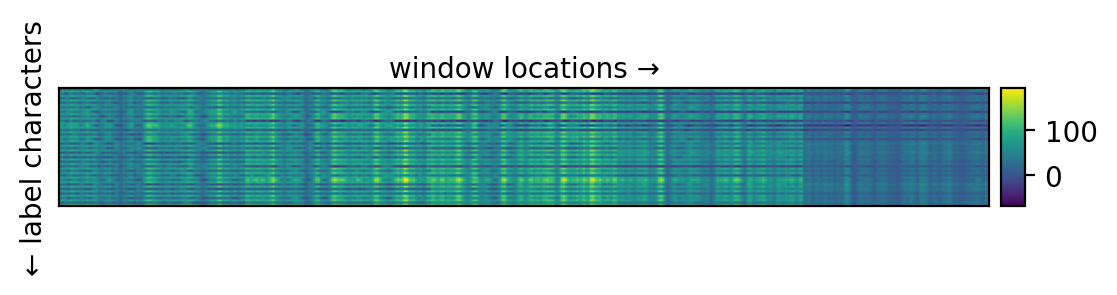

In [174]:
'''
Author: Xiang Pan
Date: 2022-03-04 22:44:31
LastEditTime: 2022-03-08 23:33:44
LastEditors: Xiang Pan
Description: 
FilePath: /HW3/hw3_practice.ipynb
@email: xiangpan@nyu.edu
'''
def plot_pm(pm, path=None):
    fig=plt.figure(dpi=200)
    ax = plt.axes()
    im = ax.imshow(pm.cpu().T)
    
    ax.set_xlabel('window locations →')
    ax.set_ylabel('← label characters')
    ax.xaxis.set_label_position('top') 
    ax.set_xticks([])
    ax.set_yticks([])
    
    if path is not None:
        for i in range(len(path) - 1):
            ax.plot(*path[i], *path[i+1], marker = 'o', markersize=0.5, linewidth=10, color='r', alpha=1)

    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im, cax=cax) 

energies = model(alphabet.cuda().view(1, 1, *alphabet.shape))
targets = transform_word(string.ascii_lowercase).unsqueeze(0).cuda()

pm = build_path_matrix(energies, targets)
plot_pm(pm[0].detach())

In [175]:
alphabet.shape

torch.Size([32, 340])

What do you see? What does the model classify correctly, and what does it have problems with?

Answer: #TODO

Searching for a good pairing $z$ is same as searching for a trajectory with a small sum of it's values in this `pm` matrix. Where does the trajectory start, and where does it end? What other properties does the trajectory have? Can you see where an optimal trajecotry would be passing through in the plot above?

Answer: #TODO

Now let's implement a function that would tell us the energy of a particular path (i.e. pairing).

In [176]:
def path_energy(pm, path):
    # inputs:
    #   pm - a matrix of energies 
    #    L - energies length
    #    T - targets length
    #   path - list of length L that maps each energy vector to an element in T
    # returns:
    #   energy - sum of energies on the path, or 2**30 if the mapping is invalid
    # TODO
    # sum the energyt along the path
    # check path is valid
    # pm = [L x T]
    L = pm.shape[0]
    T = pm.shape[1]
    if len(path) != L:
        print("path length is not equal to pm length")
        return torch.Tensor([2**30])
    e_list = [pm[i, path[i]] for i in range(L)]
    energy = torch.Tensor([sum(e_list)])
    return energy
    

Now we can check some randomly generated paths and see the associated energies for our alphabet image:

energy is 20649.1015625


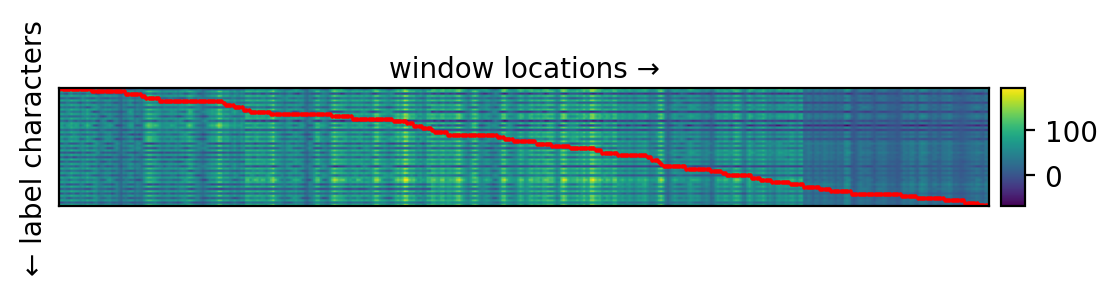

In [177]:
path = torch.zeros(energies.shape[1] - 1)
path[:targets.shape[1] - 1] = 1
path = [0] + list(map(lambda x : x.int().item(), path[torch.randperm(path.shape[0])].cumsum(dim=-1)))
points = list(zip(range(energies.shape[1]), path))

plot_pm(pm[0].detach(), points)
print('energy is', path_energy(pm[0], path).item())

Now, generate two paths with the worst possible energy, print their energies and plot them.

energy is 29773.673828125


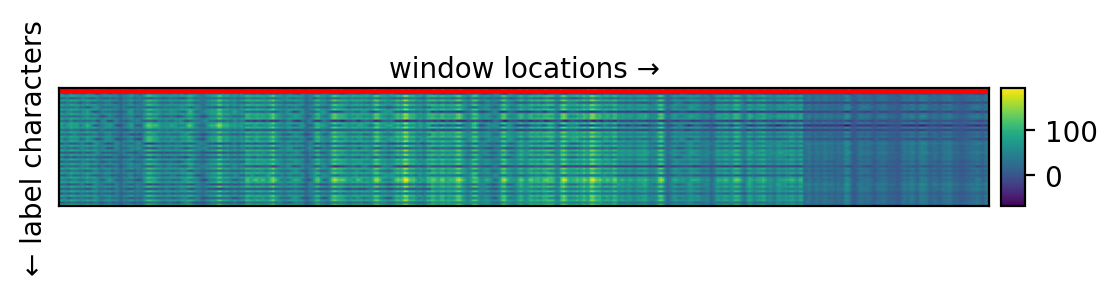

In [178]:
'''
Author: Xiang Pan
Date: 2022-03-04 22:44:31
LastEditTime: 2022-03-09 17:08:12
LastEditors: Xiang Pan
Description: 
FilePath: /HW3/hw3_practice.ipynb
@email: xiangpan@nyu.edu
'''
# TODO
# generate two worst paths
# path = [0] + list(map(lambda x : x.int().item(), torch.randperm(path.shape[0])[:targets.shape[1] - 1]))
# path = torch.Tensor(path)
# path1 = torch.zeros(energies.shape[1] - 1)
path1 = [1 for i in range(energies.shape[1])]
print('energy is', path_energy(pm[0], path1).item())
points = list(zip(range(energies.shape[1]), path1))
plot_pm(pm[0].detach(), points)

energy is 22585.27734375


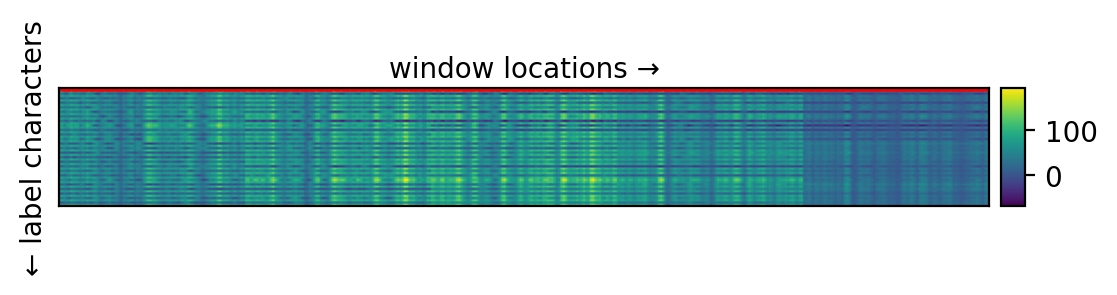

In [179]:
# TODO
# generate two worst paths
# path = [0] + list(map(lambda x : x.int().item(), torch.randperm(path.shape[0])[:targets.shape[1] - 1]))
# path = torch.Tensor(path)
# path1 = torch.zeros(energies.shape[1] - 1)
path1 = [0 for i in range(energies.shape[1])]
print('energy is', path_energy(pm[0], path1).item())
points = list(zip(range(energies.shape[1]), path1))
plot_pm(pm[0].detach(), points)

## Part - 1\: Viterbi

### Optimal path finding
Now, we're going to implement the finding of the optimal path. To do that, we're going to use Viterbi algorithm, which in this case is a simple dynamic programming problem.
In this context, it's a simple dynamic programming algorithm that for each pair i, j, calculates the minimum cost of the path that goes from 0-th index in the energies and 0-th index in the target, to i-th index in the energies, and j-th index in the target. We can memorize the values in a 2-dimensional array, let's call it `dp`. Then we have the following transitions:
```
dp[0, 0] = pm[0, 0]
dp[i, j] = min(dp[i - 1, j], dp[i - 1, j - 1]) + pm[i, j]
```

The optimal path can be recovered if we memorize which cell we came from for each `dp[i, j]`.

Below, you'll need to implement this algorithm:

In [180]:
def find_path(pm):
    # inputs:
    #   pm - a tensor of shape LxT with energies
    #     L is length of energies array
    #     T is target sequence length
    # NOTE: this is slow because it's not vectorized to work with batches.
    #  output:
    #     a tuple of three elements:
    #         1. sum of energies on the best path,
    #         2. list of tuples - points of the best path in the pm matrix 
    #         3. the dp array
    # TODO
    # find the best path
    # pm = [L x T]
    L = pm.shape[0]
    T = pm.shape[1]
    dp = torch.zeros(L, T)
    dp.fill_(2**30)
    dp[0][0] = pm[0][0]

    path = torch.zeros(L, T)
    path.fill_(-1)
    for i in range(1, L):
        for j in range(1, T):
            if dp[i-1][j] < dp[i-1][j-1]:
                dp[i][j] = dp[i-1][j] + pm[i][j]
                path[i][j] = 0   # from top
            else:
                dp[i][j] = dp[i-1][j-1] + pm[i][j]
                path[i][j] = 1   # from left top

    # pm (L, T), (energies, targets) L>T
    # best_path from left top to right bottom
    # from [L-1][T-1] to [0][0]
    best_path = []
    i = L - 1
    j = T - 1
    best_path.append((i, j))
    while i > 0 and j > 0:
        if path[i, j] == 1:
            i -= 1
            j -= 1
        else:
            i -= 1
        best_path.append((i, j))
    # best_path.append((0, 0))
    best_path.reverse()
    # assert len(best_path) == L
    return dp[L - 1, T - 1], best_path, dp

In [181]:
# m = torch.Tensor([[1, 2, 3], [1, 3 ,4], [7, 8, 9], [1, 2, 3]])
# find_path(m)

Let's take a look at the best path:

[(0, 0), (1, 1), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (10, 2), (11, 2), (12, 2), (13, 2), (14, 2), (15, 2), (16, 2), (17, 2), (18, 2), (19, 2), (20, 2), (21, 2), (22, 2), (23, 2), (24, 2), (25, 2), (26, 2), (27, 2), (28, 2), (29, 2), (30, 2), (31, 2), (32, 2), (33, 2), (34, 2), (35, 2), (36, 3), (37, 4), (38, 4), (39, 4), (40, 4), (41, 4), (42, 4), (43, 4), (44, 4), (45, 4), (46, 4), (47, 4), (48, 4), (49, 4), (50, 4), (51, 4), (52, 4), (53, 4), (54, 4), (55, 4), (56, 4), (57, 5), (58, 6), (59, 6), (60, 6), (61, 6), (62, 6), (63, 7), (64, 8), (65, 8), (66, 8), (67, 8), (68, 8), (69, 8), (70, 8), (71, 8), (72, 8), (73, 8), (74, 9), (75, 10), (76, 11), (77, 12), (78, 12), (79, 12), (80, 12), (81, 13), (82, 14), (83, 14), (84, 14), (85, 14), (86, 14), (87, 14), (88, 14), (89, 14), (90, 14), (91, 14), (92, 14), (93, 14), (94, 14), (95, 14), (96, 14), (97, 14), (98, 14), (99, 14), (100, 14), (101, 14), (102, 14), (103, 14), (104, 14), (105, 14), (106, 14), (107, 1

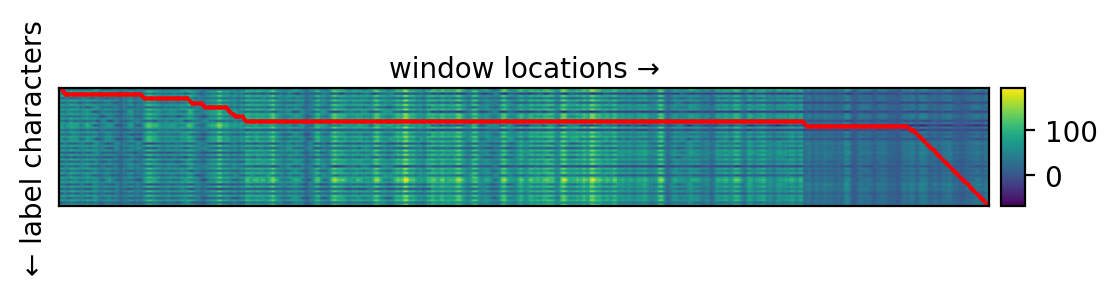

In [182]:
free_energy, path, d = find_path(pm[0])
print(path)
plot_pm(pm[0].detach(), path)
print('free energy is', free_energy.item())

We can also visualize the dp array. You may need to tune clamping to see what it looks like.

(-0.5, 409.5, 51.5, -0.5)

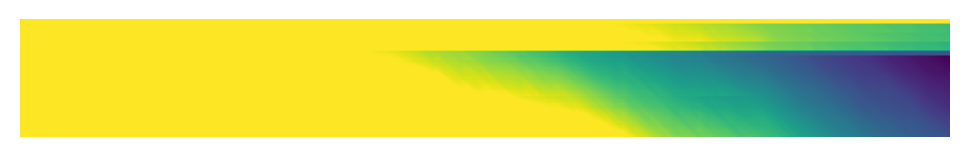

In [183]:
plt.figure(dpi=200)
plt.imshow(d.cpu().detach().T.clamp(torch.min(d).item(), 200))
plt.axis('off')

### Training loop
Now is time to train the network using our best path finder. We're going to use the energy loss function:
$$\ell(x, y) = \sum_i H(y_{z(i)}, l_i)$$
Where $z$ is the best path we've found. This is akin to pushing down on the free energy $F(x, y)$, while pushing up everywhere else by nature of cross-entropy.

#### path_cross_entropy

In [59]:
def path_cross_entropy(ce, path):
    # inputs:
    #   pm - a matrix of energies 
    #    L - energies length
    #    T - targets length
    #   path - list of length L that maps each energy vector to an element in T
    # returns:
    #   energy - sum of energies on the path, or 2**30 if the mapping is invalid
    # pm = [L x T]
    L = ce.shape[0]
    T = ce.shape[1]
    if len(path) != L:
        print("path length is not equal to ce length")
        print("path length is", len(path))
        print(path)
        return torch.Tensor([2**30]).cuda()
    energy = torch.Tensor([0]).cuda()
    for p in path:
        energy += ce[p[0]][p[1]]
    return energy

### Dataset Collect Function

In [16]:
'''
Author: Xiang Pan
Date: 2022-03-04 22:44:31
LastEditTime: 2022-03-10 02:07:20
LastEditors: Xiang Pan
Description: 
FilePath: /HW3/hw3_practice.ipynb
@email: xiangpan@nyu.edu
'''
import copy
import time

def collate_fn(samples):
    """ A function to collate samples into batches for multi-character case"""
    images, annotations = zip(*samples)
    images = list(images)
    annotations = list(annotations)
    annotations = list(map(transform_word, annotations))
    m_width = max(18, max([i.shape[1] for i in images]))
    m_length = max(3, max([s.shape[0] for s in annotations]))
    for i in range(len(images)):
        images[i] = torch.nn.functional.pad(images[i], (0, m_width - images[i].shape[-1]))
        annotations[i] = torch.nn.functional.pad(annotations[i], (0, m_length - annotations[i].shape[0]), value=BETWEEN)
    if len(images) == 1:
        return images[0].unsqueeze(0), torch.stack(annotations)
    else:
        return torch.stack(images), torch.stack(annotations)
    
sds = SimpleWordsDataset(2, 2500) # for simplicity, we're training only on words of length two

BATCH_SIZE = 32
dataloader = torch.utils.data.DataLoader(sds, batch_size=BATCH_SIZE, num_workers=0, collate_fn=collate_fn)

# TODO: 1. Create SimpleNet() model
#          To simplify the task, you can initialize the model with
#          the weights of single-character model. That would incur a 5 points
#          penalty though. 
#       2. Initialize optimizer
#       3. Train the model
# note: remember that our best path finding algorithm is not batched, so you'll
# need a for loop to do loss calculation. 
# This is not ideal, as for loops are very slow, but for 
# demonstration purposes it will suffice. In practice, this will be
# unusable for any real problem unless it handles batching.
# also: remember that the loss is the sum of cross_entropies along the path, not 
# energies!


In [186]:
'''
Author: Xiang Pan
Date: 2022-03-04 22:44:31
LastEditTime: 2022-03-09 19:34:25
LastEditors: Xiang Pan
Description: 
FilePath: /HW3/hw3_practice.ipynb
@email: xiangpan@nyu.edu
'''
import os
import time
def train_ebm_model(model, num_epochs, train_loader, criterion, optimizer, epoch=0):
    ''' Train EBM Model using find_path()'''
    pbar = tqdm(range(epoch, epoch+num_epochs))
    model.train()
    for epoch in pbar:
        start_time = time.time()
        total_train_loss = 0.0
        # TODO: implement the training loop
        #  for each batch
        #  get the pm matrix
        #  find the best path
        #  compute the cross entropy loss
        #  update the model parameters
        #  compute the free energy
        #  compute the path energy
        #  compute the total loss
        #  update the progress bar
        for i, (data, target) in enumerate(train_loader):
            # print(data.shape)
            for j in range(data.shape[0]):
                optimizer.zero_grad()
                img = data[j]
                img = img.unsqueeze(0)
                img = img.unsqueeze(1).cuda()
                tgt = target[j].cuda()
                # print(tgt)
                # print(tgt.shape)
                energies = model(img)
                # print(energies)
                # print(energies.shape, tgt.shape)
                pm = build_path_matrix(energies, tgt.unsqueeze(0))
                ce = build_ce_matrix(energies, tgt.unsqueeze(0))
                pm = pm.squeeze(0).cuda()
                ce = ce.squeeze(0).cuda()
                free_energy, path, d = find_path(pm)
                ce_along_path = path_cross_entropy(ce, path)
                loss = ce_along_path.cuda()
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()
        epoch_time = time.time() - start_time
        pbar.set_postfix({'train_loss': total_train_loss / len(sds), 'Epoch Time': epoch_time})
        print("Epoch: {}, train_loss: {}, epoch_time: {}".format(epoch, total_train_loss / len(sds), epoch_time))
        if not os.path.exists("./cached_models"):
            os.makedirs("./cached_models")
        train_loss_name = (total_train_loss / len(sds))
        train_loss_name = "{:.3g}".format(train_loss_name)
        torch.save(model.state_dict(), f"./cached_models/ebm_model_{epoch}_{train_loss_name}.pth")

# sds = SimpleWordsDataset(2, 2500) # for simplicity, we're training only on words of length two

# BATCH_SIZE = 32
# dataloader = torch.utils.data.DataLoader(sds, batch_size=BATCH_SIZE, num_workers=0, collate_fn=collate_fn)
# ebm_model = SimpleNet().cuda()
# optimizer = torch.optim.Adam(ebm_model.parameters(), lr=0.005)
# train_ebm_model(ebm_model, 30, dataloader, torch.nn.CrossEntropyLoss(), optimizer)

In [188]:
sds = SimpleWordsDataset(2, 2500) # for simplicity, we're training only on words of length two

BATCH_SIZE = 32
dataloader = torch.utils.data.DataLoader(sds, batch_size=BATCH_SIZE, num_workers=0, collate_fn=collate_fn)
ebm_model = SimpleNet().cuda()
optimizer = torch.optim.Adam(ebm_model.parameters(), lr=0.005)
train_ebm_model(ebm_model, 30, dataloader, torch.nn.CrossEntropyLoss(), optimizer)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0, train_loss: 2.3506697244951438, epoch_time: 18.80073070526123
Epoch: 1, train_loss: 0.0004153135898764219, epoch_time: 19.015364408493042
Epoch: 2, train_loss: 7.524486790206026e-05, epoch_time: 18.86797857284546
Epoch: 3, train_loss: 1.543913593053219e-05, epoch_time: 19.1043918132782
Epoch: 4, train_loss: 3.673625878406028e-06, epoch_time: 19.33482003211975
Epoch: 5, train_loss: 9.266835545588492e-07, epoch_time: 19.572927474975586
Epoch: 6, train_loss: 2.376555151101911e-07, epoch_time: 19.134053230285645
Epoch: 7, train_loss: 1.8933239459006306, epoch_time: 19.215025424957275
Epoch: 8, train_loss: 6.6695140285491945, epoch_time: 19.184468507766724
Epoch: 9, train_loss: 6.586715731811523, epoch_time: 19.172481298446655
Epoch: 10, train_loss: 6.55514870967865, epoch_time: 19.210440397262573
Epoch: 11, train_loss: 6.549227117729187, epoch_time: 19.213175296783447
Epoch: 12, train_loss: 6.542958905601502, epoch_time: 19.1529278755188


KeyboardInterrupt: 

In [187]:
ebm_model = SimpleNet().cuda()
# load
ebm_model.load_state_dict(torch.load("./cached_models/ebm_model_13.pth"))
optimizer = torch.optim.Adam(ebm_model.parameters(), lr=0.005)
train_ebm_model(ebm_model, 30, dataloader, torch.nn.CrossEntropyLoss(), optimizer, epoch=14)

RuntimeError: Error(s) in loading state_dict for SimpleNet:
	Missing key(s) in state_dict: "cnn_block.5.weight", "cnn_block.5.bias", "cnn_block.8.weight", "cnn_block.8.bias". 
	Unexpected key(s) in state_dict: "cnn_block.9.weight", "cnn_block.9.bias", "cnn_block.6.weight", "cnn_block.6.bias". 
	size mismatch for cnn_block.3.weight: copying a param with shape torch.Size([16, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 8, 5, 5]).

In [127]:
ebm_model.load_state_dict(torch.load("./cached_models/ebm_model_20.pth"))
optimizer = torch.optim.Adam(ebm_model.parameters(), lr=0.001)
train_ebm_model(ebm_model, 30, dataloader, torch.nn.CrossEntropyLoss(), optimizer, epoch=21)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 21, train_loss: 0.0016824599767227824, epoch_time: 12.331733226776123
Epoch: 22, train_loss: 4.5548803761619184e-07, epoch_time: 12.565433740615845
Epoch: 23, train_loss: 6.122543140918424e-08, epoch_time: 12.760777950286865
Epoch: 24, train_loss: 2.0456268404700494e-08, epoch_time: 12.82892632484436
Epoch: 25, train_loss: 3.767012373145917e-09, epoch_time: 12.513328313827515
Epoch: 26, train_loss: 1.0013579327505795e-09, epoch_time: 12.507550954818726
Epoch: 27, train_loss: 7.350363297389037e-05, epoch_time: 12.24721884727478
Epoch: 28, train_loss: 6.754815091341015e-07, epoch_time: 12.301571369171143
Epoch: 29, train_loss: 2.565381510351017e-08, epoch_time: 12.510879039764404
Epoch: 30, train_loss: 7.104871056640149e-09, epoch_time: 12.429613828659058
Epoch: 31, train_loss: 4.386900769759449e-09, epoch_time: 12.619577646255493
Epoch: 32, train_loss: 1.6689298234950912e-09, epoch_time: 12.683396339416504
Epoch: 33, train_loss: 0.0066472545432631645, epoch_time: 12.5202949047088

KeyboardInterrupt: 

In [134]:
ebm_model.load_state_dict(torch.load("./cached_models/ebm_model_42_4.77e-10.pth"))
optimizer = torch.optim.Adam(ebm_model.parameters(), lr=0.0005)
train_ebm_model(ebm_model, 30, dataloader, torch.nn.CrossEntropyLoss(), optimizer, epoch=43)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 43, train_loss: 2.589205487311119e-08, epoch_time: 12.599572658538818
Epoch: 44, train_loss: 1.0490414268815583e-09, epoch_time: 12.56624460220337
Epoch: 45, train_loss: 4.768371297814156e-11, epoch_time: 12.575655937194824
Epoch: 46, train_loss: 4.482258285065655e-09, epoch_time: 12.615017652511597
Epoch: 47, train_loss: 0.0, epoch_time: 12.534083843231201
Epoch: 48, train_loss: 4.510716553625116e-08, epoch_time: 12.679523468017578
Epoch: 49, train_loss: 1.1444075425970367e-09, epoch_time: 12.55000615119934
Epoch: 50, train_loss: 0.0, epoch_time: 12.55354642868042
Epoch: 51, train_loss: 0.0, epoch_time: 12.563585996627808


KeyboardInterrupt: 

In [142]:
ebm_model.load_state_dict(torch.load("./cached_models/ebm_model_51_0.pth"))
optimizer = torch.optim.Adam(ebm_model.parameters(), lr=0.0005)
train_ebm_model(ebm_model, 30, dataloader, torch.nn.CrossEntropyLoss(), optimizer, epoch=52)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 52, train_loss: 1.0181439460018282e-05, epoch_time: 12.481353521347046
Epoch: 53, train_loss: 2.193449577703177e-09, epoch_time: 12.35002589225769
Epoch: 54, train_loss: 5.245208029691639e-10, epoch_time: 12.288670539855957
Epoch: 55, train_loss: 1.4305113893442467e-10, epoch_time: 12.323354005813599
Epoch: 56, train_loss: 0.0, epoch_time: 12.29210376739502
Epoch: 57, train_loss: 1.430511332500828e-10, epoch_time: 12.400648355484009
Epoch: 58, train_loss: 0.0, epoch_time: 12.6658616065979
Epoch: 59, train_loss: 0.0, epoch_time: 12.701124429702759
Epoch: 60, train_loss: 1.430511332500828e-10, epoch_time: 12.69203519821167
Epoch: 61, train_loss: 0.0006269580494800579, epoch_time: 12.7040536403656
Epoch: 62, train_loss: 2.155270766479589e-08, epoch_time: 12.732384204864502
Epoch: 63, train_loss: 7.629393763863845e-10, epoch_time: 12.642621517181396
Epoch: 64, train_loss: 2.384185648907078e-10, epoch_time: 12.668632984161377
Epoch: 65, train_loss: 4.291533912237355e-10, epoch_time: 

### Train Result

In [192]:
ebm_model = SimpleNet().cuda()
ebm_model.load_state_dict(torch.load("./cached_models/ebm_model_79_0.pth"))

<All keys matched successfully>

Let's check what the energy matrix looks like for the alphabet image now.

free energy is -17925.623046875


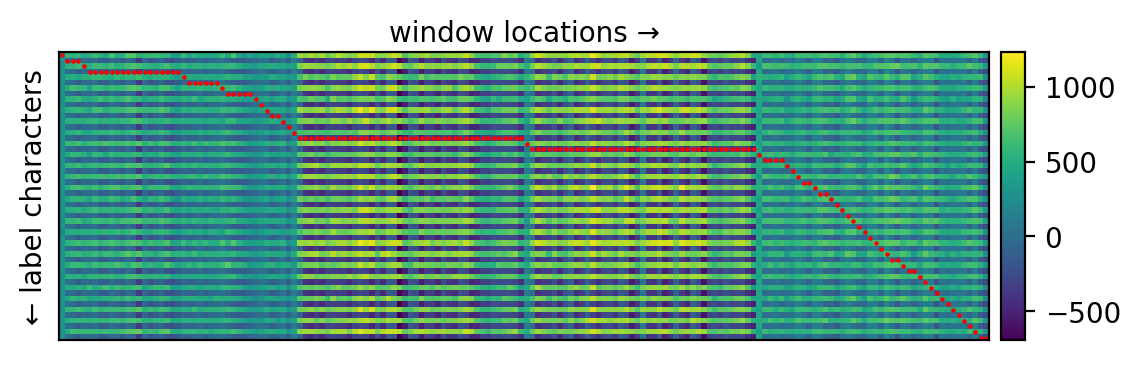

In [193]:
energies = ebm_model(alphabet.unsqueeze(0).unsqueeze(0).cuda())
targets = transform_word(string.ascii_lowercase).cuda()
pm = build_path_matrix(energies, targets.unsqueeze(0))

free_energy, path, _ = find_path(pm[0])
plot_pm(pm[0].detach(), path)
print('free energy is', free_energy.item())

There are clear seperate rigions, the left most and right most regions are the most likely to be the start and end of the word, respectively.

Explain how the free energy changed, and why.

Answer: free energy is getting smaller, because the model is optimized along the path.

We can also look at raw energies output:

(-0.5, 167.5, 26.5, -0.5)

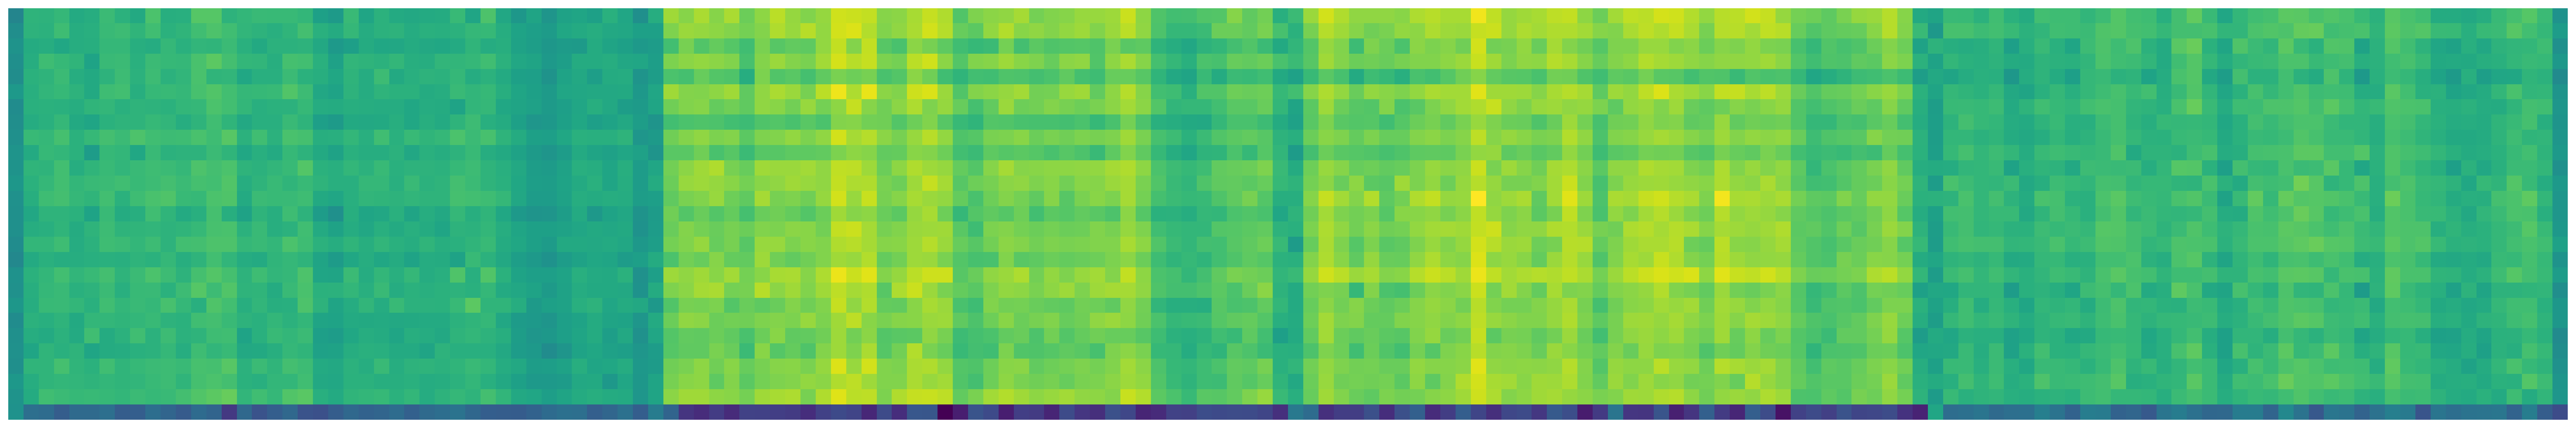

In [194]:
alphabet_energy_post_train_viterbi = ebm_model(alphabet.cuda().view(1, 1, *alphabet.shape))

plt.figure(dpi=200, figsize=(40, 10))
plt.imshow(alphabet_energy_post_train_viterbi.cpu().data[0].T)
plt.axis('off')

How does this compare to the energies we had after training only on one-character dataset?

Answer: The energies distribution is more clear seperated, and the model is more accurate.

## Decoding

Now we can use the model for decoding a word from an image. Let's pick some word, apply the model to it, and see energies. 

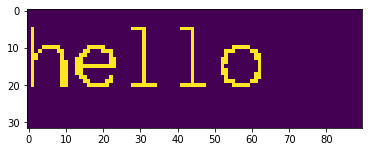

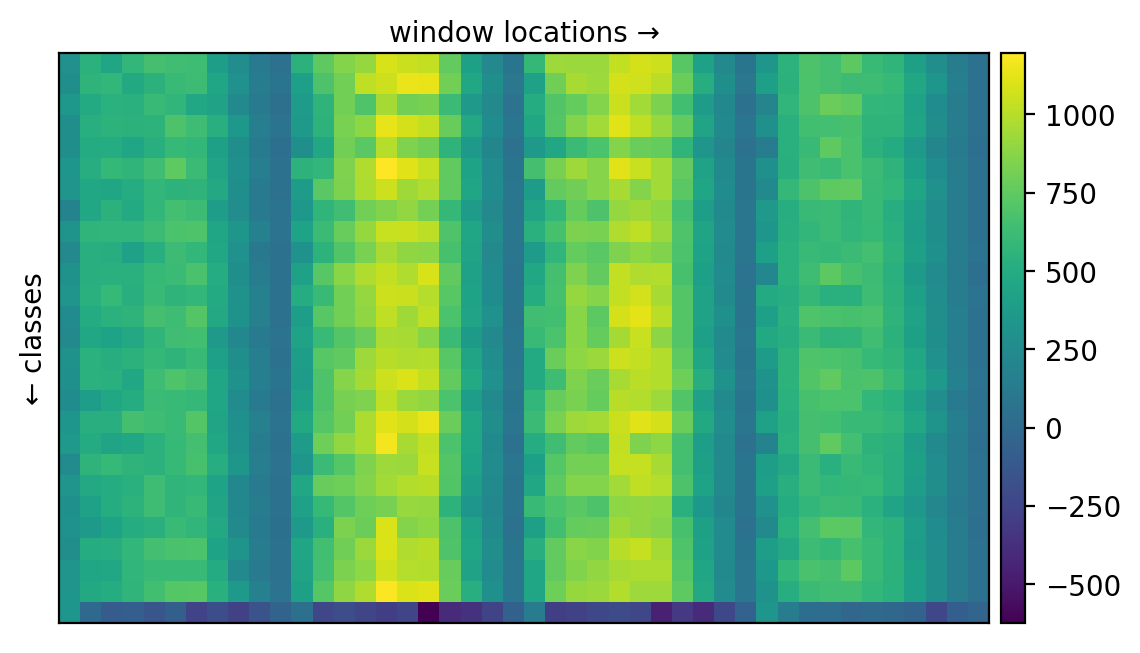

In [195]:
img = sds.draw_text('hello')
energies = ebm_model(img.cuda().unsqueeze(0).unsqueeze(0))
plt.imshow(img)
plot_energies(energies[0].detach().cpu())

You should see some characters light up. Now, let's implement a simple decoding algorithm. To decode, first we want to get most likely classes for all energies, and then do two things:
1. segment strings using the divisors (our special character with index 26), and for each segment replace it with the most common character in that segment. Example: aaab_bab_ -> a_b. If some characters are equally common, you can pick random.
2. remove all special divisor characters: a_b -> ab


In [196]:
# abcdefghijklmnopqrstuvwxyz

In [88]:
from collections import Counter
def indices_to_str(indices):
    # inputs: indices - a tensor of most likely class indices
    # outputs: decoded string
    # print(indices)
    l = indices.detach().cpu().numpy().tolist()
    print(l)
    l = ''.join([chr(i+ord('a')) for i in l])
    # print(l)
    segs = l.split('{')
    ans = ""
    for seg in segs:
        # use most common character
        if seg == '':
            continue
        a = Counter(seg).most_common()[0][0]
        ans += a
    return ans

min_indices = energies[0].argmin(dim=-1)
print(indices_to_str(min_indices))

[21, 10, 10, 10, 10, 10, 10, 10, 10, 10, 6, 12, 5, 10, 10, 5, 10, 10, 10, 10, 10, 19, 12, 5, 10, 10, 10, 10, 10, 10, 10, 10, 19, 5, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
k


In [198]:
energies.shape

torch.Size([1, 44, 27])

We trained a model with two characters, thus the decoding are mostly two characters.

In [207]:
sds = SimpleWordsDataset(5, 2500) # for simplicity, we're training only on words of length two

BATCH_SIZE = 32
dataloader = torch.utils.data.DataLoader(sds, batch_size=BATCH_SIZE, num_workers=0, collate_fn=collate_fn)
ebm_model = SimpleNet().cuda()
optimizer = torch.optim.Adam(ebm_model.parameters(), lr=0.0005)
train_ebm_model(ebm_model, 10, dataloader, torch.nn.CrossEntropyLoss(), optimizer)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0, train_loss: 17.03354627952576, epoch_time: 55.1576361656189
Epoch: 1, train_loss: 10.983816833496094, epoch_time: 55.1548798084259
Epoch: 2, train_loss: 10.371522177124023, epoch_time: 55.196656465530396
Epoch: 3, train_loss: 10.08968526916504, epoch_time: 55.19960689544678
Epoch: 4, train_loss: 10.020917481994628, epoch_time: 55.12866950035095
Epoch: 5, train_loss: 9.95420097618103, epoch_time: 55.13169717788696
Epoch: 6, train_loss: 9.90963793411255, epoch_time: 55.29002785682678
Epoch: 7, train_loss: 9.870713681030274, epoch_time: 55.12340044975281
Epoch: 8, train_loss: 9.812917861557008, epoch_time: 55.151772260665894
Epoch: 9, train_loss: 9.827949951171876, epoch_time: 55.27325940132141


In [217]:
optimizer.lr = 0.00005
train_ebm_model(ebm_model, 10, dataloader, torch.nn.CrossEntropyLoss(), optimizer, epoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 10, train_loss: 9.77627092628479, epoch_time: 56.80646562576294
Epoch: 11, train_loss: 9.776456813430785, epoch_time: 56.83791399002075
Epoch: 12, train_loss: 9.776955809783935, epoch_time: 56.83716058731079
Epoch: 13, train_loss: 9.776313111495972, epoch_time: 57.05868077278137
Epoch: 14, train_loss: 9.790047200393676, epoch_time: 57.04424047470093
Epoch: 15, train_loss: 9.784175207901, epoch_time: 57.006478786468506
Epoch: 16, train_loss: 9.775809664154053, epoch_time: 56.98968553543091
Epoch: 17, train_loss: 9.784630080032349, epoch_time: 57.29996967315674
Epoch: 18, train_loss: 9.776662043762206, epoch_time: 57.57374978065491
Epoch: 19, train_loss: 9.775883911895752, epoch_time: 57.08206248283386


In [229]:
# optimizer.lr = 0.1
# ebm_model.load_state_dict(torch.load("./cached_models/ebm_model_19_9.78.pth"))
ebm_model = SimpleNet().cuda()
optimizer = torch.optim.Adam(ebm_model.parameters(), lr=0.00005)
train_ebm_model(ebm_model, 10, dataloader, torch.nn.CrossEntropyLoss(), optimizer,epoch=20)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 20, train_loss: 9.775035766983033, epoch_time: 54.641930103302
Epoch: 21, train_loss: 9.775449541473389, epoch_time: 54.90234661102295


KeyboardInterrupt: 

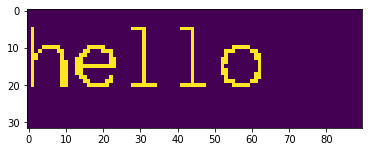

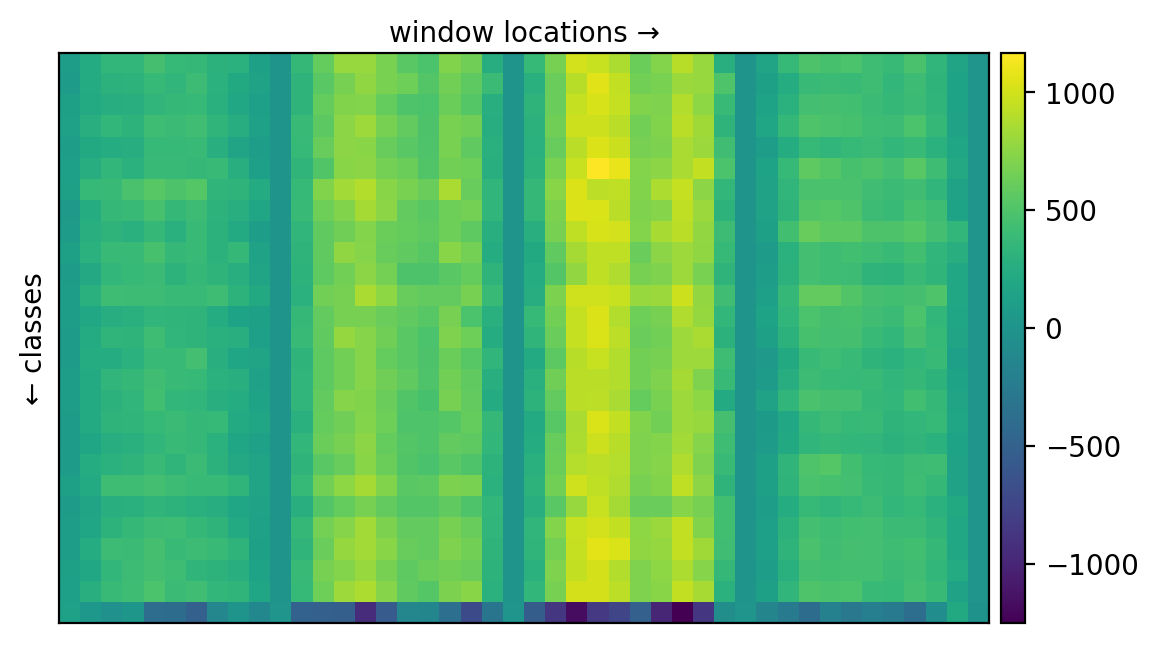

In [226]:
img = sds.draw_text('hello')
energies = ebm_model(img.cuda().unsqueeze(0).unsqueeze(0))
plt.imshow(img)
plot_energies(energies[0].detach().cpu())

In [227]:
min_indices = energies[0].argmin(dim=-1)
print(indices_to_str(min_indices))

[7, 26, 26, 26, 26, 26, 26, 26, 26, 26, 6, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 6, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 23, 26, 26, 26, 26, 26, 26, 26, 26, 26, 14, 26]
hggxo


## Part - 2\: GTN (Extra Credits, 10pts)

### CTC Loss Function

The below cell has the CTC Loss implementation which will be needed for the training. It also has the viterbi implemented, so feel free to use it.

- For calculating loss, `CTCLoss()` can be used.
- For viterbi, `CTCLossFunction.viterbi()` can be used.

### Brief Explanation\:

GTN constructs 2 graphs- 
1. Alignment graph $A_y$ that can produce a sequence of any length which when collapsed gives the output.
2. Emission graph $\mathcal{E}$ that can produce any sequence of length `L`, input's length. This can be considered as some sort of restriction over $A_y$.

Loss function is then calculated as $-\log P(y \mid X) = -(\log (A_y \circ \mathcal{E}) - \log \mathcal{E})$ where $\circ$ is the composition function.

In [53]:
!pip install gtn==0.0.0

     |████████████████████████████████| 45 kB 1.4 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for gtn: filename=gtn-0.0.0-cp39-cp39-linux_x86_64.whl size=597413 sha256=10ed9b9d35958c06b8901069a221b8a0fdae49fece92cf7e1b40b56d531cc841
  Stored in directory: /home/xiangpan/.cache/pip/wheels/48/b3/35/e9c77296fedd0e94b5aef1d726cd6d5332a58c74c27b2dd9d8
Successfully built gtn


### Reredine Dataset Here

In [12]:
import copy
import time

def collate_fn(samples):
    """ A function to collate samples into batches for multi-character case"""
    images, annotations = zip(*samples)
    images = list(images)
    annotations = list(annotations)
    annotations = list(map(transform_word, annotations))
    m_width = max(18, max([i.shape[1] for i in images]))
    m_length = max(3, max([s.shape[0] for s in annotations]))
    for i in range(len(images)):
        images[i] = torch.nn.functional.pad(images[i], (0, m_width - images[i].shape[-1]))
        annotations[i] = torch.nn.functional.pad(annotations[i], (0, m_length - annotations[i].shape[0]), value=BETWEEN)
    if len(images) == 1:
        return images[0].unsqueeze(0), torch.stack(annotations)
    else:
        return torch.stack(images), torch.stack(annotations)

In [17]:
def transform_word(s):
    # input: a string
    # output: a tensor of shape 2*len(s)
    # TODO
    l = len(s)
    # 0 to 25 is a-z
    # 26 is _
    # e = [ord(c) - ord('a') if c != '_' else 26 for c in s]
    e = []
    for c in s:
        e.append(ord(c) - ord('a'))
        e.append(26)
    e = torch.tensor(e)
    return e

In [18]:
# Credits: Adapted from https://github.com/facebookresearch/gtn_applications

import gtn
import torch

class CTCLossFunction(torch.autograd.Function):
    @staticmethod
    def create_ctc_graph(target, blank_idx):
        g_criterion = gtn.Graph(False)
        L = len(target)
        S = 2 * L + 1
        for l in range(S):
            idx = (l - 1) // 2
            g_criterion.add_node(l == 0, l == S - 1 or l == S - 2)
            label = target[idx] if l % 2 else blank_idx
            g_criterion.add_arc(l, l, label)
            if l > 0:
                g_criterion.add_arc(l - 1, l, label)
            if l % 2 and l > 1 and label != target[idx - 1]:
                g_criterion.add_arc(l - 2, l, label)
        g_criterion.arc_sort(False)
        return g_criterion

    @staticmethod
    def forward(ctx, log_probs, targets, blank_idx=0, reduction="none"):
        B, T, C = log_probs.shape
        losses = [None] * B
        scales = [None] * B
        emissions_graphs = [None] * B

        def process(b):
            # create emission graph
            g_emissions = gtn.linear_graph(T, C, log_probs.requires_grad)
            cpu_data = log_probs[b].cpu().contiguous()
            g_emissions.set_weights(cpu_data.data_ptr())

            # create criterion graph
            g_criterion = CTCLossFunction.create_ctc_graph(targets[b], blank_idx)
            # compose the graphs
            g_loss = gtn.negate(
                gtn.forward_score(gtn.intersect(g_emissions, g_criterion))
            )

            scale = 1.0
            if reduction == "mean":
                L = len(targets[b])
                scale = 1.0 / L if L > 0 else scale
            elif reduction != "none":
                raise ValueError("invalid value for reduction '" + str(reduction) + "'")

            # Save for backward:
            losses[b] = g_loss
            scales[b] = scale
            emissions_graphs[b] = g_emissions

        gtn.parallel_for(process, range(B))

        ctx.auxiliary_data = (losses, scales, emissions_graphs, log_probs.shape)
        loss = torch.tensor([losses[b].item() * scales[b] for b in range(B)])
        return torch.mean(loss.cuda() if log_probs.is_cuda else loss)

    @staticmethod
    def backward(ctx, grad_output):
        losses, scales, emissions_graphs, in_shape = ctx.auxiliary_data
        B, T, C = in_shape
        input_grad = torch.empty((B, T, C))

        def process(b):
            gtn.backward(losses[b], False)
            emissions = emissions_graphs[b]
            grad = emissions.grad().weights_to_numpy()
            input_grad[b] = torch.from_numpy(grad).view(1, T, C) * scales[b]

        gtn.parallel_for(process, range(B))

        if grad_output.is_cuda:
            input_grad = input_grad.cuda()
        input_grad *= grad_output / B

        return (
            input_grad,
            None,  # targets
            None,  # blank_idx
            None,  # reduction
        )
    
def viterbi(energies, targets, blank_idx=0):
    outputs = -1 * energies
    B, T, C = outputs.shape
    paths = [None] * B
    scores = [None] * B
    emissions_graphs = [None] * B
    def process(b):
        L = len(targets[b])
        # create emission graph
        g_emissions = gtn.linear_graph(T, C, outputs.requires_grad)
        cpu_data = outputs[b].cpu().contiguous()
        g_emissions.set_weights(cpu_data.data_ptr())

        # create criterion graph
        g_criterion = CTCLossFunction.create_ctc_graph(targets[b], blank_idx)
        g_score = gtn.viterbi_score(gtn.intersect(g_emissions, g_criterion))
        g_path = gtn.viterbi_path(gtn.intersect(g_emissions, g_criterion))
        paths[b] = [2*p if 2*p < L else i for i, p in enumerate(g_path.labels_to_list())]
        l = 0
        paths[b] = []
        for p in g_path.labels_to_list():
            if 2*p < L:
                l = p
                paths[b].append(2*p)
            else:
                paths[b].append(2*l + 1)
        scores[b] = -1 * g_score.item()
        emissions_graphs[b] = g_emissions

    gtn.parallel_for(process, range(B))

    return (scores, paths)

CTCLoss = CTCLossFunction.apply

In [69]:
class CTC(torch.nn.Module):
    def __init__(self, blank=26, use_pt=False):
        super(CTC, self).__init__()
        self.blank = blank  # index of blank label
        self.use_pt = use_pt  # use pytorch version instead of GTN

    def forward(self, inputs, targets):
        log_probs = torch.nn.functional.log_softmax(inputs, dim=2)

        if self.use_pt:
            log_probs = log_probs.permute(1, 0, 2)  # expects [T, B, C]
            input_lengths = [inputs.shape[1]] * inputs.shape[0]
            target_lengths = [t.numel() for t in targets]
            targets = torch.cat(targets)
            return torch.nn.functional.ctc_loss(
                log_probs,
                targets,
                input_lengths,
                target_lengths,
                blank=self.blank,
                zero_infinity=True,
            )
        else:
            targets = [t.tolist() for t in targets]
            return CTCLoss(log_probs, targets, self.blank, "mean")

    def viterbi(self, outputs):
        predictions = torch.argmax(outputs, dim=2).to("cpu")
        collapsed_predictions = []
        for pred in predictions.split(1):
            pred = pred.squeeze(0)
            mask = pred[1:] != pred[:-1]
            pred = torch.cat([pred[0:1], pred[1:][mask]])
            pred = pred[pred != self.blank]
            collapsed_predictions.append(pred)
        return collapsed_predictions

In [109]:
def batch_path_cross_entropy(ce, path):
    # inputs:
    #   pm - a matrix of energies 
    #    L - energies length
    #    T - targets length
    #   path - list of length L that maps each energy vector to an element in T
    # returns:
    #   energy - sum of energies on the path, or 2**30 if the mapping is invalid
    # pm = [L x T]
    B = ce.shape[0]
    L = ce.shape[1]
    T = ce.shape[2]

    path = path.unsqueeze(2).repeat(1, 1, T).long()
    output = torch.gather(ce, 2, path)
    output = output.sum()
    # print(output.shape)
    return output

In [110]:
ce = torch.rand(2, 3, 4)
energy = torch.zeros(2)
print(energy.shape)
path = [[0, 0, 0], [0, 1, 0]]
path = torch.tensor(path)
print(batch_path_cross_entropy(ce, path))

torch.Size([2])
tensor(13.7274)


### Training Function

In [114]:
'''
Author: Xiang Pan
Date: 2022-03-04 22:44:31
LastEditTime: 2022-03-10 02:51:11
LastEditors: Xiang Pan
Description: 
FilePath: /HW3/hw3_practice.ipynb
@email: xiangpan@nyu.edu
'''
from tqdm.notebook import tqdm
def train_gtn_model(model, num_epochs, train_loader, criterion, optimizer):
    ''' Train CTC Model using GTN'''
    pbar = tqdm(range(num_epochs))
    train_losses = []
    total_train_loss = 0.0
    size = 0
    free_energies = []
    paths = []
    max_grad_norm = 1
    measure = CTC()
    if torch.cuda.is_available():
        model = model.cuda()
        device = torch.device("cuda:0")
    else:
        device = torch.device("cpu")
    for epoch in pbar:
        # TODO: implement the training loop
        start_time = time.time()
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            data = data.unsqueeze(1)
            optimizer.zero_grad()

            # pm = build_path_matrix(energies, tgt.unsqueeze(0))
            # ce = build_ce_matrix(energies, tgt.unsqueeze(0))
            # pm = pm.squeeze(0).cuda()
            # ce = ce.squeeze(0).cuda()
            # free_energy, path, d = find_path(pm)
            # ce_along_path = path_cross_entropy(ce, path)

            energies = model(data)
            # log_probs = torch.nn.functional.log_softmax(-energies, dim=2)
            # loss = measure(log_probs, target)

            pm = build_path_matrix(energies, target)
            ce = build_ce_matrix(energies, target)

            scores, paths = viterbi(energies, target, blank_idx=26)
            scores = torch.Tensor(scores).to(device)
            paths = torch.Tensor(paths).to(device)
            ce_along_path = batch_path_cross_entropy(ce, paths)
            loss = ce_along_path
            # conver path

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            
            total_train_loss += loss.item()
            size += len(target)
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
        
        epoch_time = time.time() - start_time
        train_losses.append(total_train_loss)
        pbar.set_postfix({'train_loss': total_train_loss, 'Epoch Time': epoch_time})
    return

In [116]:
'''
Author: Xiang Pan
Date: 2022-03-04 22:44:31
LastEditTime: 2022-03-10 02:16:53
LastEditors: Xiang Pan
Description: 
FilePath: /HW3/hw3_practice.ipynb
@email: xiangpan@nyu.edu
'''
# Similar to what we have done earlier but instead of find_path(), we will use
# GTN's framework.

# TODO: 1. Make another copy of the single character model and initialize optimizer
# TODO: 2. Train the model
# TODO: 1. Create SimpleNet() model
#          To simplify the task, you can initialize the model with
#          the weights of single-character model. That would incur a 5 points
#          penalty though. 
#       2. Initialize optimizer
#       3. Train the model
# also: remember that the loss is the sum of cross_entropies along the path, not 
# energies!
# dataloader = torch.utils.data.DataLoader(sds, batch_size=BATCH_SIZE, num_workers=0, collate_fn=collate_fn)
# gtn_model = SimpleNet().cuda()

sds = SimpleWordsDataset(3, 2500) # for simplicity, we're training only on words of length two

BATCH_SIZE = 32
dataloader = torch.utils.data.DataLoader(sds, batch_size=BATCH_SIZE, num_workers=0, collate_fn=collate_fn)
gtn_model = SimpleNet().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
train_gtn_model(gtn_model, num_epochs=10, train_loader=dataloader, criterion=CTCLoss, optimizer=optimizer)

  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 0 [0/2500 (0%)]	Loss: 15325.406250
Train Epoch: 1 [0/2500 (0%)]	Loss: 15331.279297
Train Epoch: 2 [0/2500 (0%)]	Loss: 15347.730469
Train Epoch: 3 [0/2500 (0%)]	Loss: 15346.457031
Train Epoch: 4 [0/2500 (0%)]	Loss: 15353.505859
Train Epoch: 5 [0/2500 (0%)]	Loss: 15349.781250
Train Epoch: 6 [0/2500 (0%)]	Loss: 15342.615234
Train Epoch: 7 [0/2500 (0%)]	Loss: 15344.373047
Train Epoch: 8 [0/2500 (0%)]	Loss: 15341.144531
Train Epoch: 9 [0/2500 (0%)]	Loss: 15340.351562


### Summary
Which one of the training methods\: `train_ebm_model()`, `train_gtn_model()` is faster? Why do you think so?

Answer: #TODO

In [117]:
energies = gtn_model(alphabet.unsqueeze(0).unsqueeze(0).cuda())
targets = transform_word(string.ascii_lowercase).cuda()
pm = build_path_matrix(energies, targets.unsqueeze(0))

# TODO: Use the provided viterbi function to get score and path


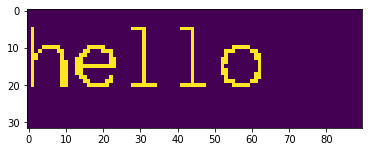

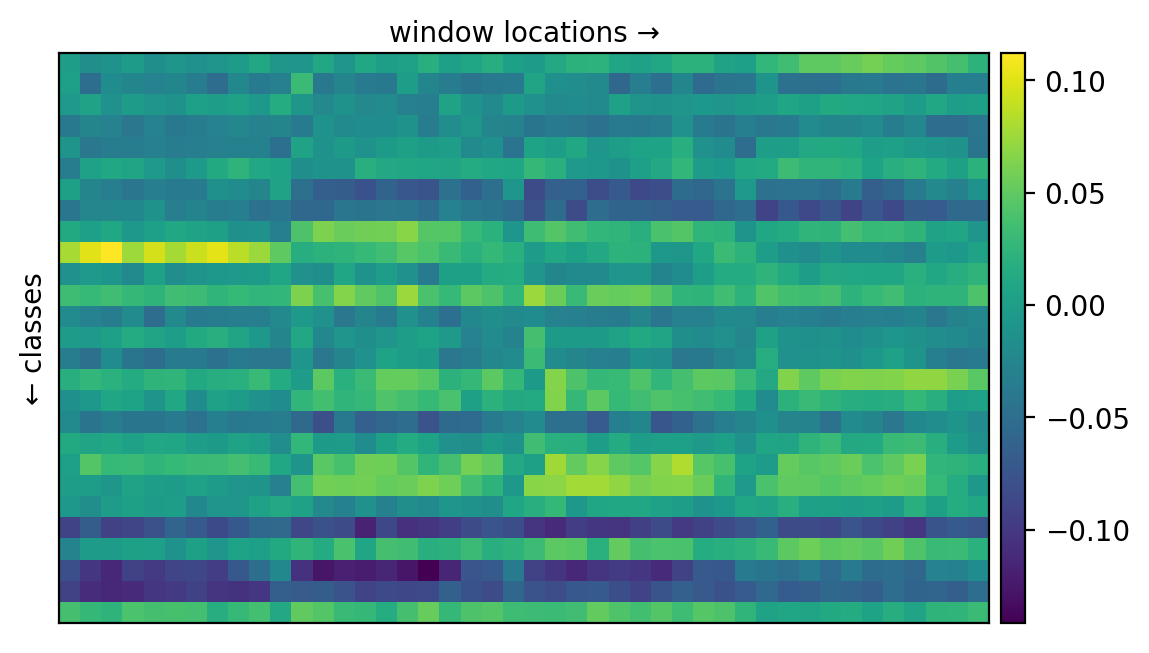

In [118]:
img = sds.draw_text('hello')
energies = gtn_model(img.cuda().unsqueeze(0).unsqueeze(0))
plt.imshow(img)
plot_energies(energies[0].detach().cpu())

In [119]:
from collections import Counter
def indices_to_str(indices):
    # inputs: indices - a tensor of most likely class indices
    # outputs: decoded string
    # print(indices)
    l = indices.detach().cpu().numpy().tolist()
    print(l)
    l = ''.join([chr(i+ord('a')) for i in l])
    print(l)
    segs = l.split('{')
    ans = ""
    for seg in segs:
        # use most common character
        if seg == '':
            continue
        a = Counter(seg).most_common()[0][0]
        ans += a
    return ans

In [120]:
min_indices = energies[0].argmin(dim=-1)
print(energies[0].shape)
# measure = CTC()
print(indices_to_str(min_indices))

torch.Size([44, 27])
[25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 24, 24, 24, 24, 24, 24, 24, 24, 22, 25, 22, 22, 22, 24, 24, 22, 24, 24, 22, 22, 22, 22, 7, 22, 7, 22, 7, 22, 22, 22, 22, 22, 22]
zzzzzzzzzzzyyyyyyyywzwwwyywyywwwwhwhwhwwwwww
w


## Part - 3\: Handwriting recognition (extra-extra credit, open-ended)

In part - 1 and part - 2, we have trained a model on a fixed font data. In this extra-extra credit section, we invite you to experiment with handwritten data. Find a dataset (or create your own) of handwritten sentences, and apply the methods from this notebook to the new dataset.
